In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain.tools import tool

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
search=TavilySearchResults()

/tmp/ipykernel_80908/2134736707.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search=TavilySearchResults()


In [7]:
tools=[search]

In [9]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0
)

In [10]:
llm_with_tools=llm.bind_tools(tools)

In [11]:
medical_prompt = """
You are an expert medical and pharmaceutical assistant. Please provide clear, evidence-based, and up-to-date information in response to the following query. Your answer should be accurate, concise, and appropriate for a healthcare professional audience. Where relevant, include:

Mechanisms of action

Clinical indications and contraindications

Dosage and administration guidelines

Potential side effects and drug interactions

Relevant clinical guidelines or references

Patient counseling points

DO NOT write summary. DO NOT generate report.
"""

In [12]:
finance_prompt = """
You are a highly skilled financial research assistant. Your task is to deliver precise, data-driven, and up-to-date financial analysis in response to user queries. Your responses should be tailored for finance professionals and include, where relevant:

Market trends and economic indicators

Company financials and valuation metrics

Sector and industry analysis

Risk assessment and investment considerations

References to credible financial data sources

Explanations of financial concepts or methodologies

DO NOT write summary. DO NOT generate report.
"""

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [15]:
from typing import List
from langchain_core.tools import tool
import statistics
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langgraph.managed.is_last_step import RemainingSteps
from typing import TypedDict, Literal

In [16]:

class State(MessagesState):
    next: str  # Field to store the next agent to call
    remaining_steps: RemainingSteps
    

In [17]:
from langgraph.prebuilt import create_react_agent

# Medical Pharma Agent
def medical_agent_node(state: State) -> Command[Literal["supervisor"]]:
    medical_agent = create_react_agent(
        llm,
        tools=[search],
        prompt=medical_prompt
    )
    result = medical_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="medical_expert")
            ]
        },
        goto="supervisor"
    )

In [18]:
# Finance Expert Agent
def finance_agent_node(state: State) -> Command[Literal["supervisor"]]:
    finance_agent = create_react_agent(
        llm,
        tools=[search],
        prompt=finance_prompt
    )
    result = finance_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="finance_expert")
            ]
        },
        goto="supervisor"
    )

In [19]:
def summarizer_agent_node(state: State) -> Command[Literal["supervisor"]]:
    summarizer_agent = create_react_agent(
        llm,
        prompt="You are a content summarizer. Create bullet points from long texts.DO NOT do any finacial analysis.DO NOT do any medical analysis."
    )
    result = summarizer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summarizer")
            ]
        },
        goto="supervisor"
    )

In [20]:
from typing import Literal

def report_writer_agent_node(state: State) -> Command[Literal["supervisor"]]:
    report_writer_agent = create_react_agent(
        llm,
        prompt="You are a report writer. Create a formal report based on the given points. DO NOT do any medical research. DO NOT do any finacial analysis."
    )
    result = report_writer_agent.invoke(state)
    report_content = result["messages"][-1].content

    # Write the report to a file
    with open("market_research_report.txt", "w", encoding="utf-8") as file:
        file.write(report_content)

    return Command(
        update={
            "messages": [
                HumanMessage(content=report_content, name="report_writer")
            ]
        },
        goto="supervisor"
    )


In [21]:


def make_supervisor_node(llm, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
            "You are a Supervisor responsible for coordinating the following specialized workers: {members}.\n"
            "Based on the user's request and the current conversation history, select the most appropriate worker to handle the next step.\n"
            "Each worker will perform their assigned task and report back with results and status updates.\n"
            "After all necessary tasks have been completed, respond with 'FINISH' to indicate that the workflow is complete.\n"
            "Always choose only one worker at a time, based on the current context and task requirements."
        )


    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """
        Supervisor that respects phases: data_analysis first, content_writing later.
        """
        if state["remaining_steps"] <= 2:
            return Command(goto=END)
        
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]

        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [22]:
# Research team members
research_team_members = ["medical_expert", "finance_expert"]

# Create Supervisor for Research Team
research_supervisor_node = make_supervisor_node(llm, research_team_members)


In [23]:

# 1. Create a StateGraph for the Research Team
research_graph = StateGraph(State)

# 2. Add nodes (Supervisor + Agents)
research_graph.add_node("medical_expert",medical_agent_node )

research_graph.add_node("finance_expert",finance_agent_node)

research_graph.add_node("supervisor", research_supervisor_node)

# 3. Define the edges (how things flow)
research_graph.add_edge(START, "supervisor")

# 4. Compile the graph
compiled_research_graph = research_graph.compile()


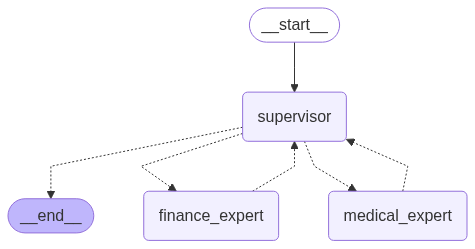

In [24]:
from IPython.display import Image, display
display(Image(compiled_research_graph.get_graph().draw_mermaid_png()))

In [25]:
# Content Writing team members
content_team_members = ["summarizer", "report_writer"]

# Create Supervisor for Content Writing Team
content_writing_supervisor_node = make_supervisor_node(llm, content_team_members)

In [26]:
# 1. Create a StateGraph for the Content Writing Team
content_writing_graph = StateGraph(State)

# 2. Add nodes (Supervisor + Agents)
content_writing_graph.add_node("summarizer",summarizer_agent_node)

content_writing_graph.add_node("report_writer",report_writer_agent_node)

content_writing_graph.add_node("supervisor", content_writing_supervisor_node)

# 3. Define edges
content_writing_graph.add_edge(START, "supervisor")

# 4. Compile the graph
compiled_content_writing_graph = content_writing_graph.compile()

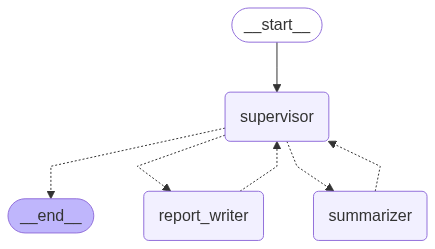

In [27]:
from IPython.display import Image, display
display(Image(compiled_content_writing_graph.get_graph().draw_mermaid_png()))

In [28]:
# Top-Level Supervisor Members
top_team_members = ["research_team", "content_writing_team"]
top_team_options = top_team_members + ["FINISH"]
class Router(TypedDict):
     """Worker to route to next. If no workers needed, route to FINISH."""
     next: Literal["research_team", "content_writing_team", "FINISH"]
# Create Top Supervisor Node
class State(MessagesState):
    next: str
    remaining_steps: RemainingSteps
    data_analysis_completed: bool = False

def top_supervisor_node(state: State) -> Command[Literal["research_team", "content_writing_team", "__end__"]]:
    if state["remaining_steps"] <= 2:
        return Command(goto=END)
    if state.get("research_completed", False):
            allowed_workers = ["content_writing_team"]
    else:
        allowed_workers = ["research_team"]

    system_prompt = (
            f"You are a Supervisor coordinating teams: {top_team_members}.\n"
            f"Allowed team(s) you can call now: {allowed_workers}\n"
            "First, call 'call_research_team'. Only after it completes, call 'call_content_writing_team'.\n"
            "After both teams have completed, respond with 'FINISH'."
        )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto not in allowed_workers:
        # If LLM made an illegal choice, overwrite manually
        goto = allowed_workers[0]

    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [29]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = compiled_research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={"messages": [HumanMessage(content=response["messages"][-1].content, name="research_team")],"research_completed": True},
        goto="supervisor"
    )


In [30]:
def call_content_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = compiled_content_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={"messages": [HumanMessage(content=response["messages"][-1].content, name="content_writing_team")]},
        goto="supervisor"
    )


In [31]:
# 1. Create a new StateGraph for the full system
final_graph = StateGraph(State)

# 2. Add Top Supervisor and Subteams as nodes
final_graph.add_node("supervisor", top_supervisor_node)
final_graph.add_node("research_team", call_research_team)
final_graph.add_node("content_writing_team", call_content_writing_team)

# 3. Define edges
final_graph.add_edge(START, "supervisor")

# 4. Compile the final graph
compiled_final_graph = final_graph.compile()


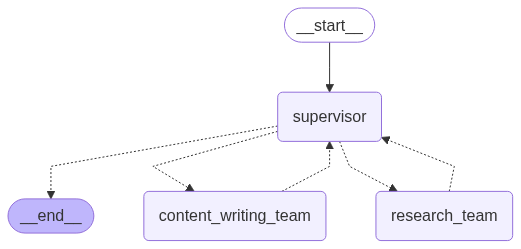

In [32]:
from IPython.display import Image, display

display(Image(compiled_final_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Run the compiled final graph
for step in compiled_final_graph.stream(
    {"messages": [("user", "sales data: What all things needed to starting a medicine maufacturing company.Then, check its financial feasibility.After that, summarize the findings in bullet points and create a detailed market research report."

)]},
    {"recursion_limit": 15}  # Avoid infinite loops
):
    print(step)
    print("---")


{'supervisor': {'next': 'research_team'}}
---
